In [1]:
import pandas as pd
from collections import Counter

In [2]:
labels = open('files/labels.txt').readlines()
counter = {}
sample_label = {}

# mapping samples to classes
for label in labels:
    sample, cls = label.split(':')
    cls = int(cls.strip())
    sample_label[sample] = cls
    if cls not in counter:
        counter[cls] = [sample]
    else:
        counter[cls].append(sample)

# selecting classes with more than 50 samples
selected = []
cls_counter = 0
selected_cls = []
for cls in counter:
    if len(counter[cls]) > 50:
        selected_cls.append(cls)
        selected.extend(counter[cls])
        cls_counter += 1

print('Total num of classes:', cls_counter)

# List of samples' id
samples = list(map(str.strip, open('files/gtex_samples.txt').readlines()))
sample_index = {s: i for i, s in enumerate(samples)}
# +2 because samples' enumeration starts from 2 in dataframe
selected = [sample_index[sample] + 2 for sample in selected]

Total num of classes: 48


In [3]:
######################## Functions for reducing gtex file ########################

# get rows with same gene_id and replace with their mean
def remove_duplicates(df):
    repeated = set()
    counter = Counter()
    cls = list(df)[2:]
    for gene in df['gene_id'].tolist():
        counter[gene] += 1
        if counter[gene] > 1:
            repeated.add(gene)
    c = 0
    print('Number of repeating genes: ', len(repeated))
    for gene in repeated:
        q = df[df.gene_id == gene][cls]
        mean = q.mean()
        mean['gene_id'] = gene
        df = df.drop(q.index)
        df = df.append(mean, ignore_index=True)
        c += 1
    return df

# merge chuncks of big gtex file
def merge_chunks():
    genes = map(str.strip, open('files/common_genes.txt').readlines())
    df_seq = []

    for start in range(0, 58000, 2000):
        if start == 0:
            df = pd.read_csv('chunks/{}_{}.csv'.format(start, start + 2000), skiprows=[0, 1], sep='\t', header=None)
        else:
            df = pd.read_csv('chunks/{}_{}.csv'.format(start, start + 2000), skiprows=[0], sep='\t', header=None)
        #df = df[df[1].isin(genes)]
        df = df.drop(0, axis='columns')
        print(start, df.shape)
        df_seq.append(df)

    return pd.concat(df_seq)

# select common genes of gtex and rsem
def select_common(df):
    common_genes = map(str.strip, open('files/common_genes.txt').readlines())
    df['gene_id'] = df['gene_id'].map(lambda gene: gene.split('|')[0])
    return df[df.gene_id.isin(common_genes)]

##########################################################

def reduce_rsem(path):
    path = 'files/' + path + '.txt'
    df = pd.read_csv(path, sep='\t', skiprows=[0])
    df = select_common(df)
    df = remove_duplicates(df)
    df = df[filter(lambda c: c == 'gene_id' or c.startswith('scaled'), list(df))].sort_values(by='gene_id')
    name = path.split('/')[1].replace('txt', 'csv')
    df.to_csv('files/' + name)

def to_row(sample_index, features):
    features = map(str, features.tolist())
    return {'class': sample_label[samples[int(sample_index) - 2]], 'features': ' '.join(features)}

# dataset generation from dataframe

def gen_normal_tissues_ds(df):
    rows = []
    for sample_id in list(df):
        rows.append(to_row(sample_id, df[sample_id]))
    return pd.DataFrame(rows)

def gen_cancer_tissues_ds(files):
    cancer_cls = max(selected_cls) + 1
    rows = []
    for i, f in enumerate(files):
        df = pd.read_csv('files/{}.csv'.format(f))
        for col in list(df)[2:]:
            features = map(str, df[col].tolist())
            rows.append({'class': cancer_cls + i, 'features': ' '.join(features)})
    return pd.DataFrame(rows)

In [ ]:
# read gtex file to chunks
gtex = pd.read_csv('files/gtex.gct', chunksize=2000)
i = 0
for chunk in gtex:
    start = i * 2000
    chunk.to_csv('chunks/{}_{}.csv'.format(start, start + 2000))
    i += 1

In [ ]:
gtex = merge_chunks()
gtex.columns = gtex.iloc[0]
gtex = gtex.drop(0, axis='rows')
columns = {sample: i + 2 for i, sample in enumerate(gtex.columns[1:])}
columns.update({'Description': 'gene_id'})
gtex = gtex.rename(columns, axis='columns')
gtex = select_common(gtex)
gtex = remove_duplicates(gtex)
gtex = gtex.sort_values(by='gene_id')

0 (1999, 11689)
2000 (2000, 11689)
4000 (2000, 11689)
6000 (2000, 11689)
8000 (2000, 11689)
10000 (2000, 11689)
12000 (2000, 11689)
14000 (2000, 11689)
16000 (2000, 11689)
18000 (2000, 11689)
20000 (2000, 11689)
22000 (2000, 11689)
24000 (2000, 11689)
26000 (2000, 11689)
28000 (2000, 11689)
30000 (2000, 11689)
32000 (2000, 11689)
34000 (2000, 11689)
36000 (2000, 11689)
38000 (2000, 11689)
40000 (2000, 11689)
42000 (2000, 11689)
44000 (2000, 11689)
46000 (2000, 11689)
48000 (2000, 11689)
50000 (2000, 11689)
52000 (2000, 11689)
54000 (2000, 11689)
56000 (203, 11689)
Number of repeating genes:  109


In [ ]:
# dataset with normal tissues
normal_tissues = gtex.loc[:, ~gtex.columns.isin(['Unnamed: 0', 'Unnamed: 0.1'])]
normal_tissues = normal_tissues[selected]
nt_ds = gen_normal_tissues_ds(normal_tissues)

In [ ]:
# dataset with cancers
cancers = ['ACC', 'BLCA', 'BRCA', 'GBM', 'GBMLGG', 'KIPAN', 'LUAD',
           'OV', 'STES', 'HNSC', 'COADREAD', 'COAD', 'LGG', 'KIRC', 'CESC']
for cancer in cancers:
    reduce_rsem(cancer)
cancer_ds = gen_cancer_tissues_ds(cancers)

In [ ]:
total_ds = pd.concat([nt_ds, cancer_ds]).sample(frac=1)
total_ds.to_csv('full_ds.csv')

In [95]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 220

In [80]:
ntoclass = {}
cancers = ['ACC', 'BLCA', 'BRCA', 'GBM', 'GBMLGG', 'KIPAN', 'LUAD', 'OV', 'STES', 'HNSC', 'COADREAD', 'COAD', 'LGG', 'KIRC', 'CESC']
clss = open('files/tissues.txt').readlines()
available = set(clf.classes_)

for l in clss:
    cls, n = l.split('–')
    if int(cls) in available:
        ntoclass[int(cls)] = n.strip()
ntoclass.update(dict(zip(range(54, 69), cancers)))

In [81]:
labels = [ntoclass[cl] for cl in keys]

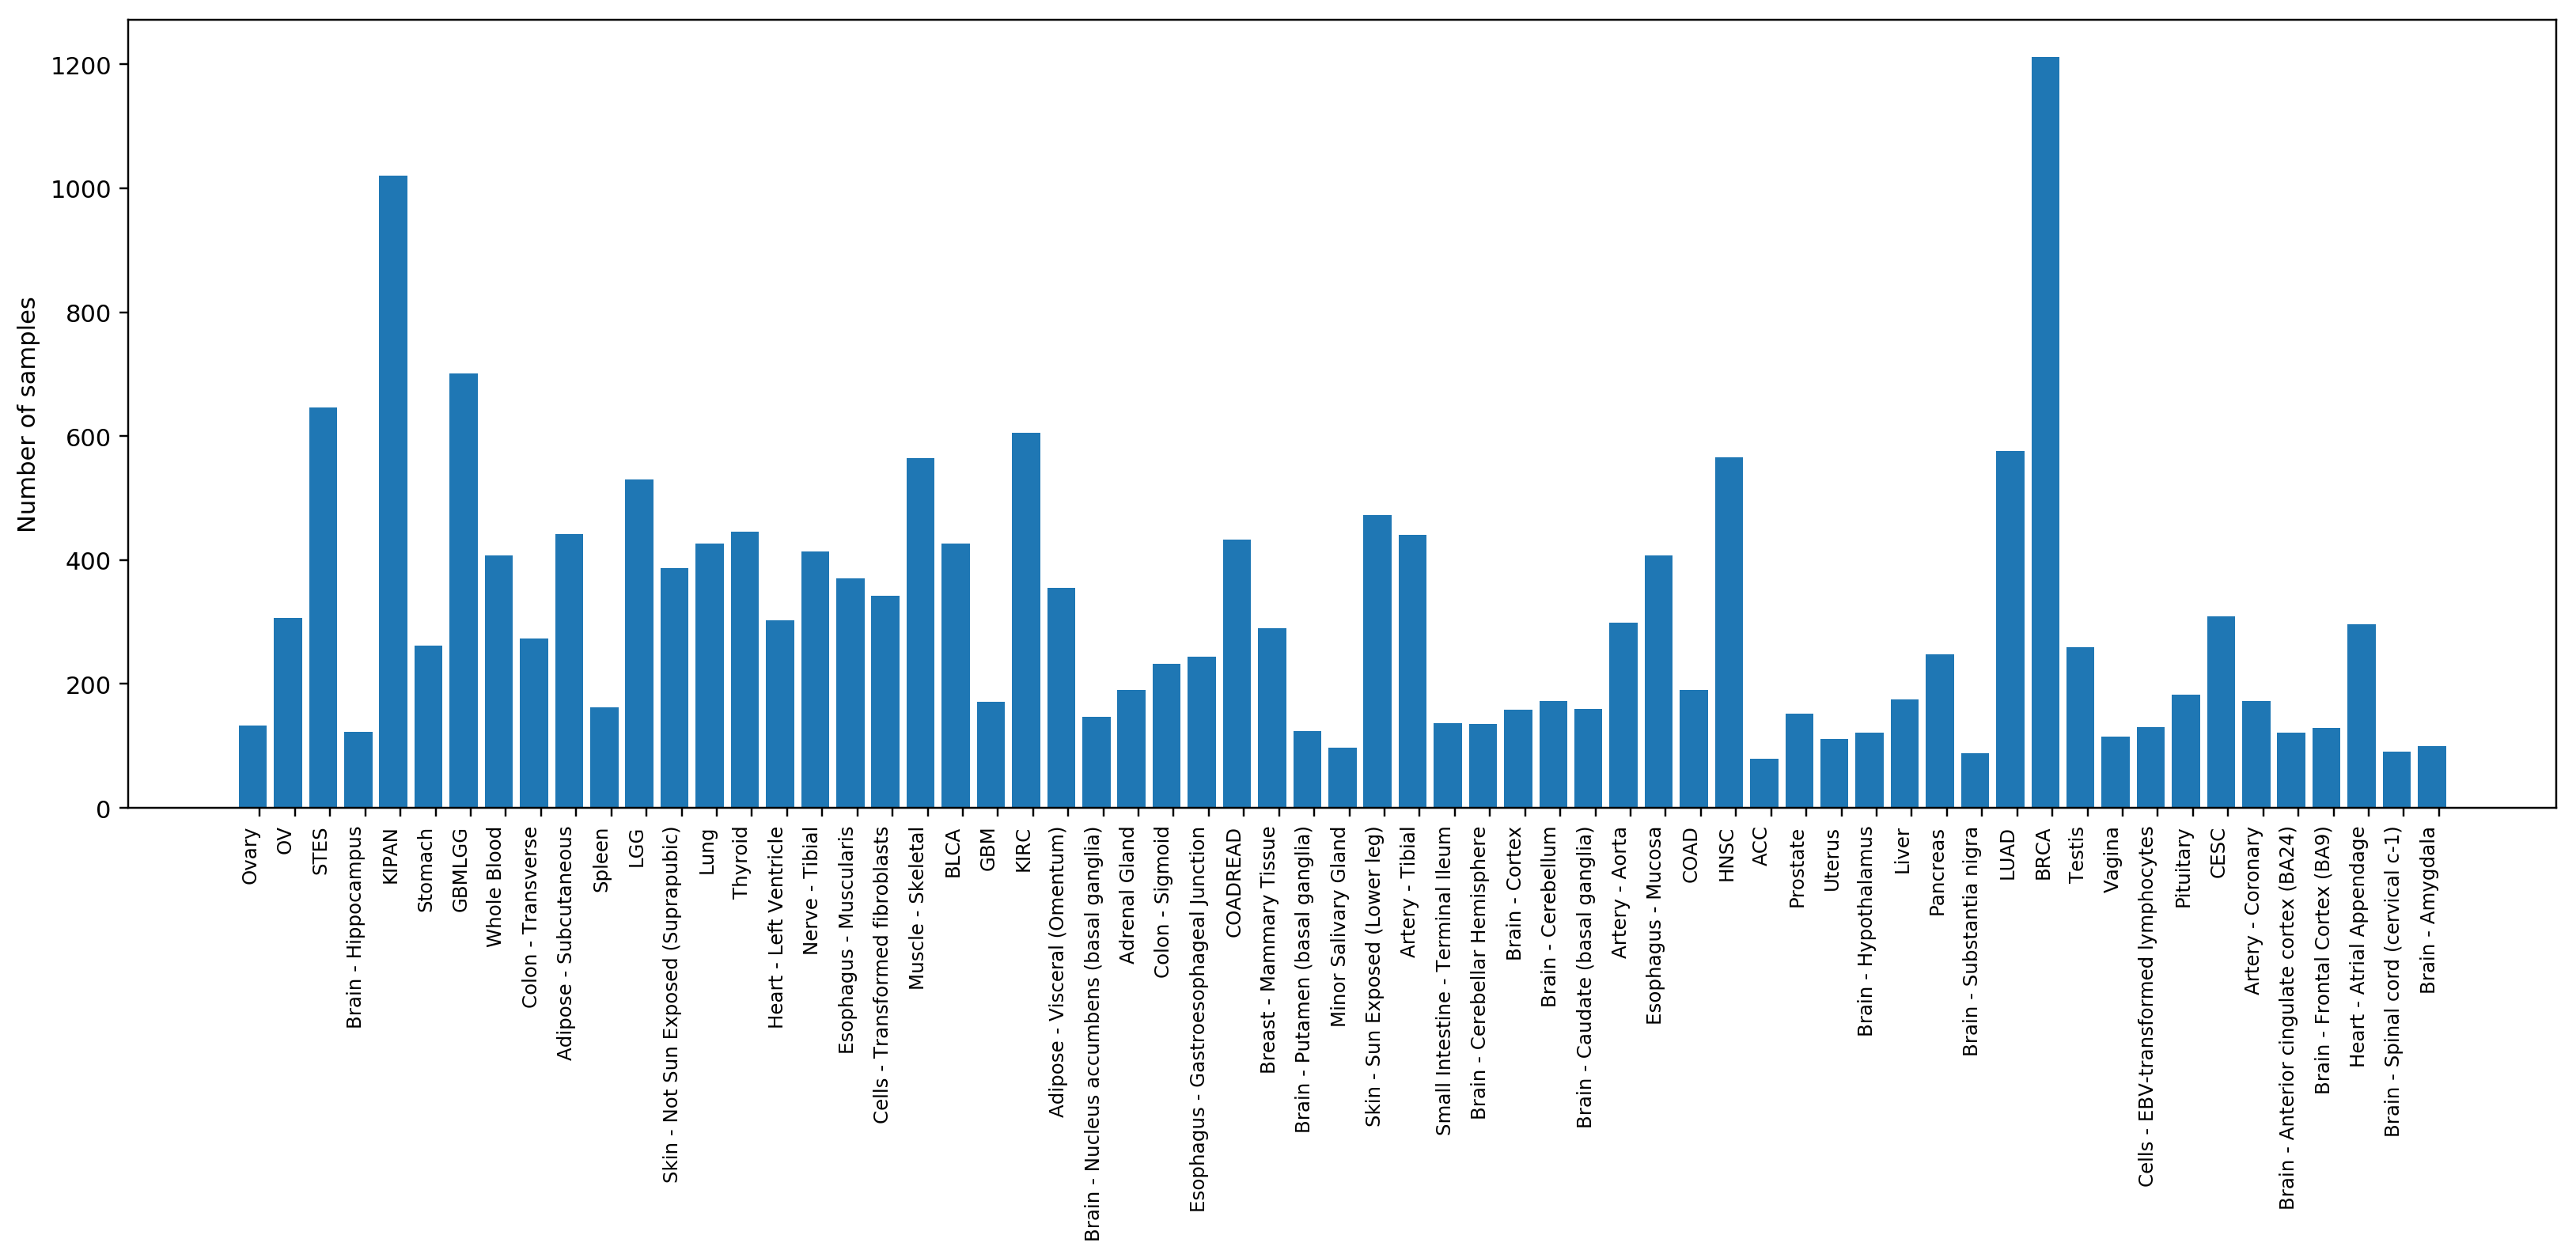

In [100]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.bar(0.5 + np.arange(len(labels)), x)
ax.set_xticks(0.7 + np.arange(len(labels)))
ax.set_xticklabels(labels, rotation='vertical', ha="right", fontsize=8)
ax.set_ylabel('Number of samples')
plt.show()